In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
one = pd.read_csv('SingleInferenceTask_data_processed.csv')
three = pd.read_csv('InferenceTask_data_processed.csv')
one.head()

,survey_name,unit_position,type,item_name,label,answer,display_order,subject,premise,y,condition
0,Single_Inference_Task,10,rating_button,pr1au9,...disobeys his boss; nothing bad happens as a...,6,57,0,lo,au,9
1,Single_Inference_Task,10,rating_button,pr1sa9,...marries his first cousin in an elaborate we...,3,66,0,lo,sa,9
2,Single_Inference_Task,10,rating_button,pr1li9,...forces his daughter to enroll as a pre-med ...,4,51,0,lo,li,9
3,Single_Inference_Task,10,rating_button,pr1fa9,...bribes his landlord to be the first to get ...,5,22,0,lo,fa,9
4,Single_Inference_Task,10,rating_button,pr1ca9,...is driving along an empty road and sees a w...,4,77,0,lo,ca,9


In [2]:
# Checking the distribution of the premises. Also gives a list of the distinct labels. 
three['premise'].value_counts()

li3         819
sa3         819
ca3         266
po_au_lo    210
po3         189
fa3         189
lo3         168
fa_ca_lo    126
po_fa_au     91
po_lo_au     84
au_fa_po     77
au_lo_ca     77
po_au_fa     70
ca_fa_lo     63
au_po_fa     21
Name: premise, dtype: int64

In [3]:
one['premise'].value_counts()

sa1    847
li1    833
po     315
fa     231
lo     224
au      77
Name: premise, dtype: int64

In [4]:
# Creating a dataframe with averaged participant responses in each unique premise/conclusion combination (1-example premise)
one_avg = pd.DataFrame()
one_avg['answer'] = one.groupby(['premise','y'])['answer'].mean()
one_avg['std'] = one.groupby(['premise','y'])['answer'].std()
one_avg['n_premises'] = 1
one_avg.head()

answer       std  n_premises
premise y                                 
au      au  3.727273  1.954017           1
        ca  5.090909  1.513575           1
        fa  4.909091  1.136182           1
        li  4.363636  1.689540           1
        lo  4.636364  1.963300           1

In [5]:
# Creating a dataframe with averaged participant responses in each unique premise/conclusion combination (3-example premise)
three_avg = pd.DataFrame()
three_avg['answer'] = three.groupby(['premise','y'])['answer'].mean()
three_avg['std'] = three.groupby(['premise','y'])['answer'].std()
three_avg['n_premises'] = 3
three_avg.head()

answer       std  n_premises
premise  y                                 
au_fa_po au  6.090909  0.831209           3
         ca  5.090909  1.578261           3
         fa  3.818182  2.088932           3
         li  5.272727  1.009050           3
         lo  5.727273  1.348400           3

In [6]:
# Concatenating the data for 1 and 3 example premises into a single dataframe
# Separating the premise and conclusion into columns instead of the index
data = pd.concat([one_avg,three_avg])[['answer','std','n_premises']]
data = data.reset_index()
print(data.shape)
data.head()

(147, 5)


,premise,y,answer,std,n_premises
0,au,au,3.727273,1.954017,1
1,au,ca,5.090909,1.513575,1
2,au,fa,4.909091,1.136182,1
3,au,li,4.363636,1.689540,1
4,au,lo,4.636364,1.963300,1


In [7]:
%%capture 
%run ../model_implementation.ipynb

In [8]:
# Checking that all premises occur exactly 7 times each (because participant responses are averaged for each of 7 conclusions)
data['premise'].value_counts()

li1         7
po_au_lo    7
au          7
sa1         7
fa          7
po_lo_au    7
fa_ca_lo    7
au_lo_ca    7
ca_fa_lo    7
au_fa_po    7
au_po_fa    7
lo          7
ca3         7
po_au_fa    7
fa3         7
po_fa_au    7
po          7
lo3         7
po3         7
li3         7
sa3         7
Name: premise, dtype: int64

In [9]:
# Using a fixed lambda value of 0.1, compute the model prediction for that premise/conclusion combination and add to the data
lambda_param = 0.1
for index,row in data.iterrows():
    premise = row['premise']
    if len(premise) == 2:
        # single premise case, propriety violation
        premise = [premise]
    elif len(premise) == 3 and premise[2] == str(1):
        # single premise case, need to remove extra number on end
        premise = [premise[0:2]]
    elif len(premise) == 3 and premise[2] == str(3):
        # 3 premise case, all same category
        premise = [premise[0:2],premise[0:2],premise[0:2]]
    else:
        # 3 premise case, all different propriety
        premise = premise.split('_')
    
    for y in compute_all_probabilities(premise,lambda_param):
        if y[0] == row['y']:
            data.at[index,'model_prediction'] = y[1]
data.head()

,premise,y,answer,std,n_premises,model_prediction
0,au,au,3.727273,1.954017,1,1.000000
1,au,ca,5.090909,1.513575,1,0.381255
2,au,fa,4.909091,1.136182,1,0.381255
3,au,li,4.363636,1.689540,1,0.176494
4,au,lo,4.636364,1.963300,1,0.381255


In [10]:
# Filling in all undefined std (i.e. premise/conclusion combos with only 1 data point) with std=1. 
data = data.fillna(1)
data.head()

,premise,y,answer,std,n_premises,model_prediction
0,au,au,3.727273,1.954017,1,1.000000
1,au,ca,5.090909,1.513575,1,0.381255
2,au,fa,4.909091,1.136182,1,0.381255
3,au,li,4.363636,1.689540,1,0.176494
4,au,lo,4.636364,1.963300,1,0.381255


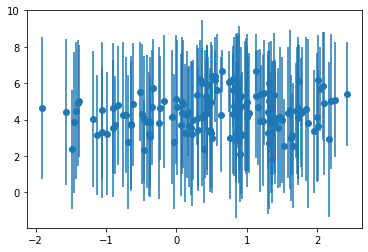

In [11]:
# Plotting data with error bars
# adding up to 1 std of random noise to the model prediction, to make the bars more separate
import random
model_noise = [round(random.uniform(-x, x), 2) for x in data['std']] 
#model_noise = [0 for x in data['std']]
plt.errorbar(data['model_prediction']+model_noise, data['answer'], xerr=0, yerr=2*data['std'], linestyle='', fmt="o")
plt.show()

Text(0, 0.5, 'Participant Responses (Average)')

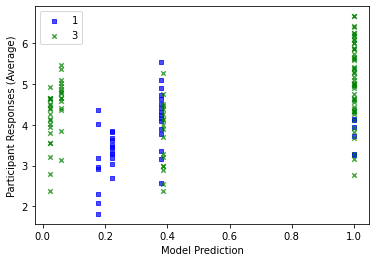

In [12]:
# plot the data
import matplotlib.pyplot as plt
from mlxtend.plotting import category_scatter
fig = category_scatter(x='model_prediction', y='answer', label_col='n_premises', data=data, legend_loc='upper left')
plt.xlabel('Model Prediction')
plt.ylabel('Participant Responses (Average)')
# data.plot.scatter(x='answer',y='model_prediction')

In [13]:
data[['answer','model_prediction']].corr()

,answer,model_prediction
answer,1.000000,0.441695
model_prediction,0.441695,1.000000


In [14]:
# write to file
data.to_csv('final_data.csv',index=False)

In [15]:
# Fitting lambda parameter
param_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
max_abs_corr = -1
best_param = 0
for lambda_param in param_values:
    for index,row in data.iterrows():
        premise = row['premise']
        if len(premise) == 2:
            # single premise case, propriety violation
            premise = [premise]
        elif len(premise) == 3 and premise[2] == str(1):
            # single premise case, need to remove extra number on end
            premise = [premise[0:2]]
        elif len(premise) == 3 and premise[2] == str(3):
            # 3 premise case, all same category
            premise = [premise[0:2],premise[0:2],premise[0:2]]
        else:
            # 3 premise case, all different propriety
            premise = premise.split('_')

        for y in compute_all_probabilities(premise,lambda_param):
            if y[0] == row['y']:
                data.at[index,'model_prediction'] = y[1]
    corr = data[['answer','model_prediction']].corr()['model_prediction'].iloc[0]
    if abs(corr) > max_abs_corr:
        max_abs_corr = abs(corr)
        best_param = lambda_param

print('best param:',lambda_param)
print('max absolute correlation:',max_abs_corr)

best param: 0.9
max absolute correlation: 0.4507244871651099


In [16]:
# Generating bar chart
data.head()

,premise,y,answer,std,n_premises,model_prediction
0,au,au,3.727273,1.954017,1,1.000000
1,au,ca,5.090909,1.513575,1,0.245119
2,au,fa,4.909091,1.136182,1,0.245119
3,au,li,4.363636,1.689540,1,0.656790
4,au,lo,4.636364,1.963300,1,0.245119


In [17]:
data['premise'].unique()

array(['au', 'fa', 'li1', 'lo', 'po', 'sa1', 'au_fa_po', 'au_lo_ca',
       'au_po_fa', 'ca3', 'ca_fa_lo', 'fa3', 'fa_ca_lo', 'li3', 'lo3',
       'po3', 'po_au_fa', 'po_au_lo', 'po_fa_au', 'po_lo_au', 'sa3'],
      dtype=object)

In [18]:
# Group these unique premises into Propriety, Liberty, and Sanctity (so we can plot 1 vs 3 examples)
def grp(x):
    if len(x) == 2:
        return 'pr'
    elif len(x) == 3 and x[0:2] in ['li','sa']:
        return x[0:2]
    elif len(x) == 3:
        return 'pr'
    elif x[0:2] in ['ca','fa','au','lo','po']:
        return 'pr'
    else:
        return x[0:2]

In [19]:
data['premise_combined'] = [grp(x) for x in data['premise']]
data['premise_combined'].unique()

array(['pr', 'li', 'sa'], dtype=object)

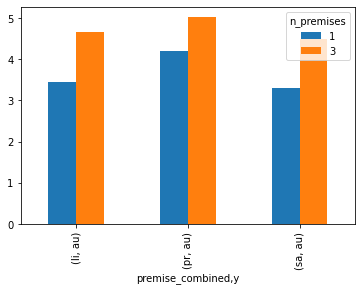

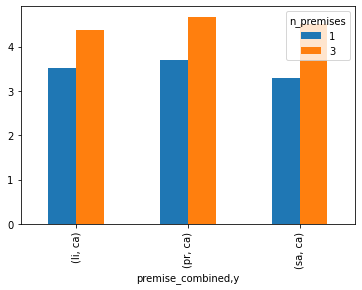

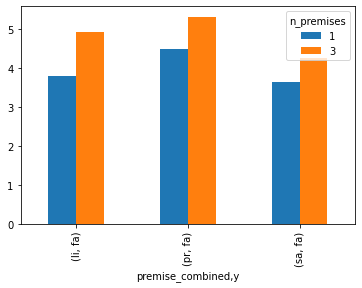

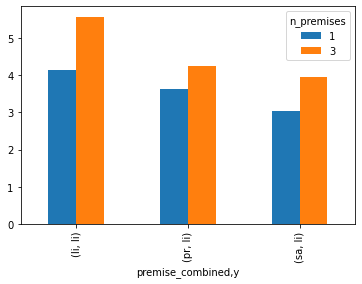

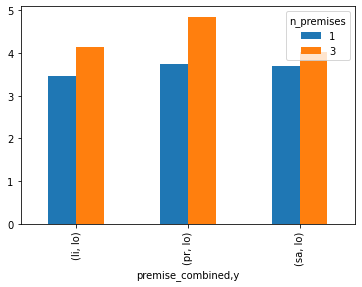

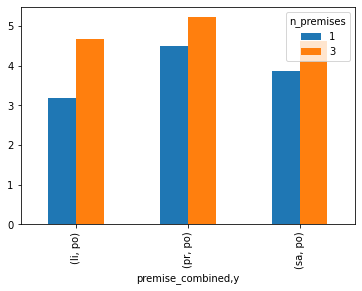

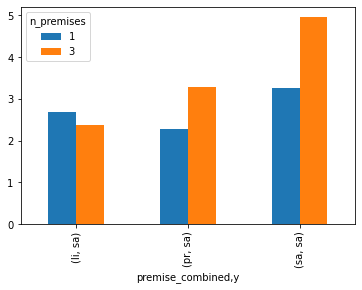

In [28]:
# Creating barcharts to compare 1 vs 3 premise examples
df_pivot = pd.pivot_table(
    data, 
    values="answer",
    index=["premise_combined",'y'],
    columns="n_premises", 
    aggfunc=np.mean
)
df_pivot.groupby('y').plot.bar()